In [44]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [45]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [46]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
DATA = './data/meteo_16.9_51.103333_2025-11-30_2022-11-13.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date']

MODEL_NAME = 'model_v1_sequential'
SAVE_PATH = './models'

In [47]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])

print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------+--------------------------+----------------+-----------+--------+----------------+------------+--------------+---------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0cm |   soil_moisture_0_to_1cm |   pressure_msl |   showers |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+------------------------+--------------------------+----------------+-----------+--------+----------------+------------+--------------+---------------|
|  0 | 2022-11-13 14:00:00+00:00 |           8

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26721 entries, 0 to 26720
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   date                    26721 non-null  datetime64[ns, UTC]
 1   temperature_2m          26721 non-null  float64            
 2   relative_humidity_2m    26721 non-null  float64            
 3   apparent_temperature    26721 non-null  float64            
 4   surface_pressure        26721 non-null  float64            
 5   wind_direction_10m      26721 non-null  float64            
 6   wind_speed_10m          26721 non-null  float64            
 7   soil_temperature_0cm    26721 non-null  float64            
 8   soil_moisture_0_to_1cm  26721 non-null  float64            
 9   pressure_msl            26721 non-null  float64            
 10  showers                 26721 non-null  float64            
 11  rain                    26721 non-null  f

In [49]:
print(df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    26721.000000          26721.000000          26721.000000   
mean        10.791490             75.652240              8.588359   
std          8.232080             16.596451              9.728562   
min        -14.295500             20.000000            -18.407337   
25%          4.304500             66.000000              0.732825   
50%         10.304501             80.000000              7.789615   
75%         17.004500             89.000000             16.210533   
max         34.954500            100.000000             35.786564   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      26721.000000        26721.000000    26721.000000   
mean        1001.084605          201.535256       10.844102   
std            8.922235           89.285595        6.151426   
min          967.780330            1.080910        0.000000   
25%          995.691700          130.601210        6.162207   


In [50]:
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()


print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 16032
Validation size: 5344
Test size: 5345


In [51]:
scaler = StandardScaler()
feature_columns = [col for col in df.columns if col not in DROP_FEATURES]

scaler.fit(train_df[feature_columns])

train_df[feature_columns] = scaler.transform(train_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

print(train_df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    1.603200e+04          1.603200e+04          1.603200e+04   
mean    -1.917960e-16          1.825996e-16          1.281964e-16   
std      1.000031e+00          1.000031e+00          1.000031e+00   
min     -2.836053e+00         -3.354506e+00         -2.656950e+00   
25%     -7.894609e-01         -5.811401e-01         -8.066366e-01   
50%     -6.070404e-02          2.629279e-01         -8.722181e-02   
75%      7.470012e-01          8.055431e-01          7.818168e-01   
max      2.933271e+00          1.468739e+00          2.790520e+00   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      1.603200e+04        1.603200e+04    1.603200e+04   
mean      -9.566422e-15        2.260334e-17    1.121303e-16   
std        1.000031e+00        1.000031e+00    1.000031e+00   
min       -3.714965e+00       -2.258004e+00   -1.762342e+00   
25%       -6.009268e-01       -7.985342e-01   -7.567792e-01   


In [52]:
def extract_Xy(dataframe):
    X = dataframe.drop(columns=DROP_FEATURES + [TARGET_FET])
    y = dataframe[TARGET_FET]
    return X, y

X_train, y_train = extract_Xy(train_df)
X_val, y_val = extract_Xy(val_df)
X_test, y_test = extract_Xy(test_df)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(16032, 14) (16032,)
(5344, 14) (5344,)
(5345, 14) (5345,)


In [53]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

print(model.summary())

Model: "model_v1_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [54]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0235 - mae: 0.0655 - val_loss: 0.0036 - val_mae: 0.0335 - learning_rate: 0.0100
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - mae: 0.0306 - val_loss: 0.0033 - val_mae: 0.0441 - learning_rate: 0.0100
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mae: 0.0254 - val_loss: 0.0029 - val_mae: 0.0356 - learning_rate: 0.0100
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - mae: 0.0224 - val_loss: 0.0011 - val_mae: 0.0201 - learning_rate: 0.0100
Epoch 5/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mae: 0.0236 - val_loss: 6.9358e-04 - val_mae: 0.0182 - learning_rate: 0.0100
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9089e-04 - mae: 0.0182 - val_loss: 8.2685e-04 - val_mae: 0.0186 - learning_rate: 0.0100
Epoch 7/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - mae: 0.0238 - val_loss: 8.9596e-04 - val_mae: 0.0153 - learn

In [ ]:
os.makedirs(os.path.join(SAVE_PATH,MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler.pkl'))

['./models/model_v1_sequential/scaler.pkl']

=== TRAINING ===


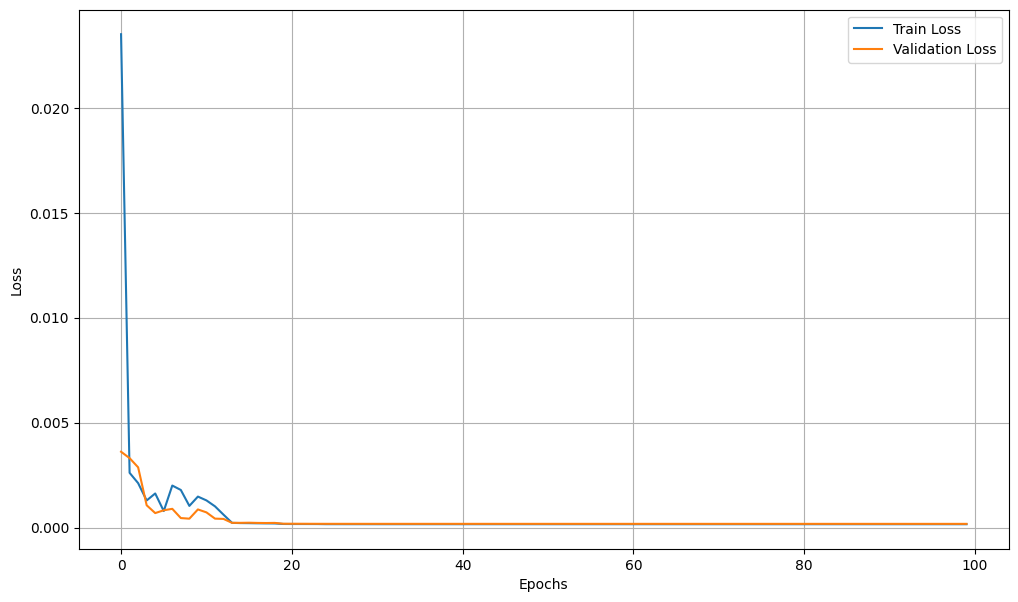

In [56]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [57]:
mae_scaled = model.evaluate(X_test, y_test)[1]

predictions = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(np.hstack((X_test, predictions)))[:, -1]
test_y_rescaled = scaler.inverse_transform(np.hstack((X_test, y_test.values.reshape(-1, 1))))[:, -1]

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].values,
    'Predicted': pred_rescaled,
    'Actual': test_y_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6889e-04 - mae: 0.0062
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== TEST ===
Test MAE on scaled data: 0.006
Test MAE rescaled to original values: 0.237

+------+---------------------+-------------+-------------+
|      | Data                |   Predicted |      Actual |
|------+---------------------+-------------+-------------|
| 4515 | 2022-11-13 23:00:00 |  39.0618    |  39.2403    |
| 3003 | 2022-11-14 01:00:00 |  38.4167    |  38.6013    |
| 3196 | 2022-11-14 03:00:00 |  39.9358    |  40.1108    |
| 2626 | 2022-11-14 06:00:00 |  36.3921    |  36.5388    |
| 1527 | 2022-11-14 14:00:00 |  63.4912    |  63.7171    |
| 1236 | 2022-11-14 15:00:00 |  59.8864    |  60.0319    |
| 1978 | 2022-11-15 06:00:00 |  33.9255    |  33.8923    |
|  440 | 2022-11-15 19:00:00 |  55.254     |  55.3842    |
| 4336 | 2022-11-15 21:00:00 |  55.9683    |  56.0148    |
| 3771 | 2022-11-16 02:00:00 |  51.9423    |  52.0925    |
|  326 | 2022-11-16 09:00:00